# ロックイン検出とヘテロダイン解析

高周波の搬送波（キャリア）に情報が載っているような信号から、振幅や位相のゆっくりとした変化を抽出する手法を **ロックイン検出（Lock-in detection）** または **ヘテロダイン検波（Heterodyne detection）** と呼びます。

このチュートリアルでは、以下の流れで解析を実演します。

1.  **変調信号の生成**: 100Hzのキャリア信号に対し、ゆっくりとした振幅変調と位相ドリフトを加え、強めのノイズを混合します。
2.  **ロックイン検出 (`lock_in`)**: `gwexpy` の `lock_in` メソッドを使用して、参照周波数に基づいた振幅と位相の自動抽出を行います。
3.  **マニュアル復調 (`mix_down`)**: 信号に参照波（正弦波と余弦波）を掛け合わせて低域フィルタを通す、より原理的なプロセスを体験します。
4.  **結果の比較**: 抽出された振幅・位相と、最初にシミュレーションした変調信号を比較し、その精度を確認します。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries

## 1. 変調信号のシミュレーション (Simulated Signal)

以下の成分を持つ信号を作成します：
*   **キャリア**: 100 Hz
*   **振幅変調 (AM)**: 0.2 Hz の正弦波的な変動
*   **位相変調 (PM)**: 0.05 Hz のゆっくりとしたドリフト
*   **ノイズ**: 白色雑音


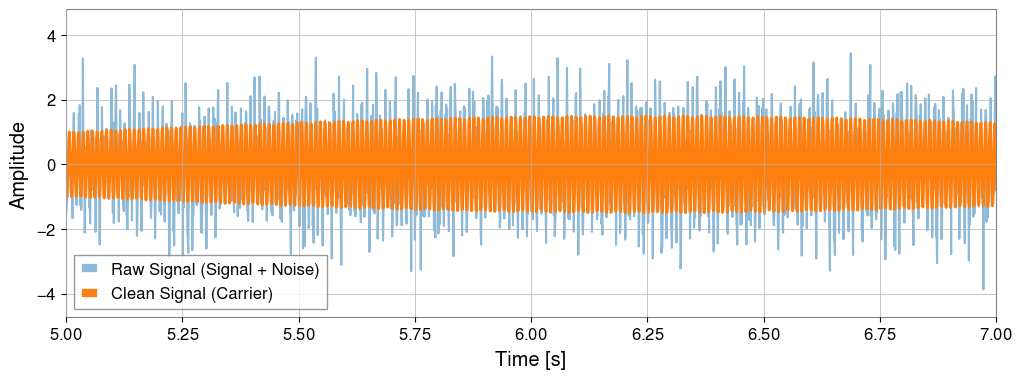

In [2]:
fs = 1024.0      # サンプリング周波数 [Hz]
duration = 40.0  # データ長 [s]
t = np.arange(0, duration, 1/fs)

np.random.seed(42)

# 1. 搬送波 (Carrier)
f_carrier = 100.0

# 2. 振幅変調 (Amplitude Modulation)
# 1.0 を中心に +/- 0.5 変動
amp_mod = 1.0 + 0.5 * np.sin(2 * np.pi * 0.2 * t)

# 3. 位相変調 (Phase Modulation / Drift)
# ラジアン単位での位相のズレ
phase_mod = 2.0 * np.sin(2 * np.pi * 0.05 * t)

# --- 信号の合成 ---
# x(t) = A(t) * sin(2*pi*f_c*t + phi(t))
clean_signal = amp_mod * np.cos(2 * np.pi * f_carrier * t + phase_mod)

# ノイズを付加
noise = np.random.normal(0, 0.8, len(t))
ts = TimeSeries(clean_signal + noise, sample_rate=fs, name="Modulated Signal", unit="V")

# 可視化
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts, alpha=0.5, label="Raw Signal (Signal + Noise)")
ax.plot(ts.times, clean_signal, label="Clean Signal (Carrier)", linewidth=2)
ax.set_xlim(5, 7) # 一部を拡大
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

# ノイズが大きく、このままでは振幅や位相の変動を目視で捉えるのは困難です。


## 2. ロックイン検出 (Extracting Amplitude and Phase)

`gwexpy` の `lock_in()` メソッドを使用すると、指定した周波数 `f0` における振幅と位相のトレンドを簡単に抽出できます。
内部的には、信号を復調（複素ヘテロダイン）し、`stride` 秒ごとの平均値を計算します。


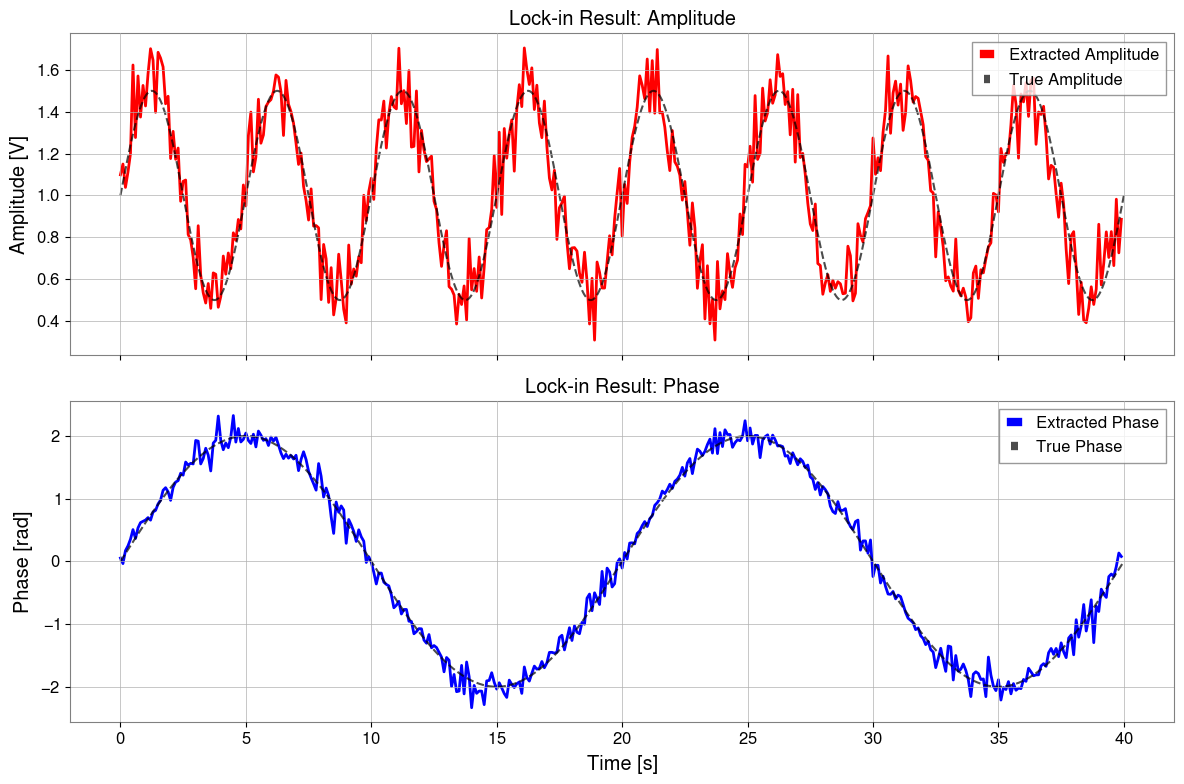

In [3]:
# stride=0.1s (10Hz相当) で振幅と位相を抽出
#出力形式は 'amp_phase' (デフォルト)
amp, phase = ts.lock_in(f0=f_carrier, stride=0.1, output='amp_phase', deg=False)

# プロット
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(amp, label="Extracted Amplitude", color="red", linewidth=2)
ax1.plot(t, amp_mod, label="True Amplitude", color="black", ls="--", alpha=0.7)
ax1.set_ylabel("Amplitude [V]")
ax1.legend()
ax1.set_title("Lock-in Result: Amplitude")

ax2.plot(phase, label="Extracted Phase", color="blue", linewidth=2)
ax2.plot(t, phase_mod, label="True Phase", color="black", ls="--", alpha=0.7)
ax2.set_ylabel("Phase [rad]")
ax2.legend()
ax2.set_title("Lock-in Result: Phase")

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

# ノイズに埋もれていた信号から、元の変調が見事に復元されていることが分かります。


## 3. マニュアル復調 (Manual Demodulation / Mixing)

ロックインの内部動作を知るために、手動でも復調を行ってみましょう。
1.  参照波（$\cos(2 \pi f_c t)$ と $\sin(2 \pi f_c t)$）を掛け合わせます。
2.  低域フィルタ（Low-pass filter）で高周波成分（$2 f_c$ 成分）とノイズを除去します。
3.  I（実部）と Q（虚部）から振幅と位相を計算します。


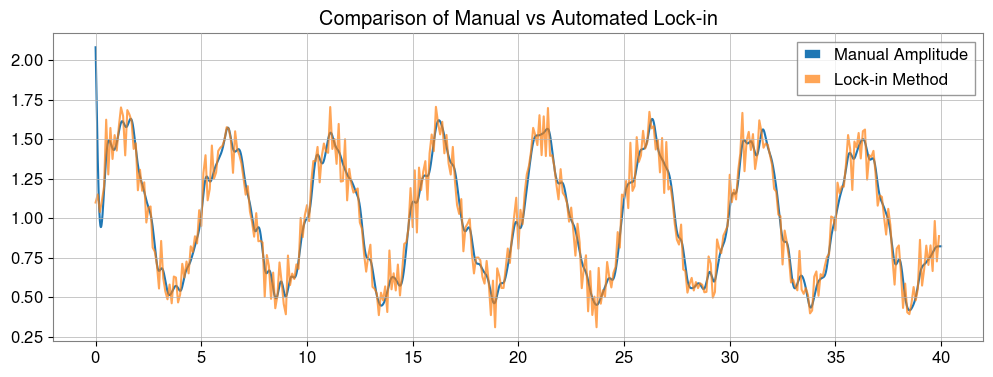

In [4]:
# 1. ミキシング (Mixing)
# gwexpy の mix() は、与えられた波形との積を計算します。
ref_cos = np.cos(2 * np.pi * f_carrier * t)
ref_sin = np.sin(2 * np.pi * f_carrier * t)

# 2*np.cos * ref_cos => 1.0 + cos(2*2*pi*f_c*t)
mixed_i = (ts * ref_cos) * 2.0
mixed_q = (ts * (-ref_sin)) * 2.0 # 位相の定義により符号反転

# 2. 低域フィルタ (Low-pass Filter)
# キャリア周波量(100Hz)より十分低い 2Hz などの LPF を通す
b, a = signal.butter(4, 2.0, fs=fs, btype='low')
i_filtered = TimeSeries(signal.filtfilt(b, a, mixed_i.value), sample_rate=fs)
q_filtered = TimeSeries(signal.filtfilt(b, a, mixed_q.value), sample_rate=fs)

# 3. 振幅と位相の算出
amp_manual = np.sqrt(i_filtered**2 + q_filtered**2)
phase_manual = np.arctan2(q_filtered.value, i_filtered.value)

# 可視化 (Step 2 と同様の結果が得られるはずです)
plt.figure(figsize=(12, 4))
plt.plot(amp_manual, label="Manual Amplitude")
plt.plot(amp, label="Lock-in Method", alpha=0.7)
plt.title("Comparison of Manual vs Automated Lock-in")
plt.legend()
plt.show()


## 4. スペクトル領域での理解

復調した信号のスペクトルを見ると、本来 100Hz 付近にあった微細な構造が、0Hz（DC）付近に移動していることが分かります。


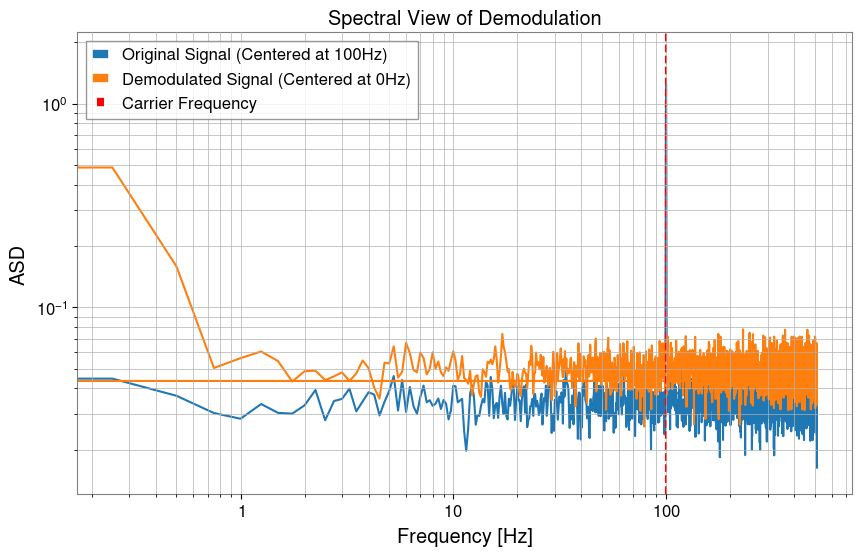

In [5]:
# 元の信号の ASD
asd_raw = ts.asd(fftlength=4)
# 復調後の複素信号 (出力 'complex' を使用)
complex_signal = ts.lock_in(f0=f_carrier, stride=1/fs, output='complex')
asd_demod = complex_signal.asd(fftlength=4)

plt.figure(figsize=(10, 6))
plt.loglog(asd_raw.frequencies, asd_raw.value, label="Original Signal (Centered at 100Hz)")
plt.loglog(asd_demod.frequencies, asd_demod.value, label="Demodulated Signal (Centered at 0Hz)")
plt.axvline(f_carrier, color="red", ls="--", label="Carrier Frequency")

plt.title("Spectral View of Demodulation")
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD")
plt.legend()
plt.grid(True, which="both")
plt.show()

# ロックイン解析によって、高周波に存在する目的の情報を、
# 低周波のトレンド解析の手法で扱えるようになったことが分かります。


## 5. gwpy と gwexpy の手法の比較

gwpyの既存メソッド（`.heterodyne()`, `.demodulate()`）と、gwexpyで追加された `.lock_in()` は、どちらも「特定の周波数の信号成分を取り出す」という目的は同じですが、**「時間分解能」と「フィルタリング手法」**に決定的な違いがあります。一言で言うと、gwpyは「定常信号の平均値」を見るためのものであり、gwexpyは「信号強度の時間変化（過渡応答）」を見るためのものです。

### 1. gwpy: `.heterodyne()` / `.demodulate()`
これらは **「積分（平均化）」** に基づく手法です。

*   **仕組み**: データを指定した時間幅（`stride`、デフォルト1秒）で区切り、その区間内で参照信号（$e^{-i\omega t}$）と掛け合わせて単純平均を取ります。
*   **フィルタ特性**: 時間領域での矩形窓（Boxcar window）による平均化を行うため、周波数領域では sinc関数 の特性を持ちます。
*   **出力**: `stride` 毎に1点のデータになります（サンプリングレートが激減します）。
*   **欠点**:
    *   **時間分解能が低い**: 1秒間の平均値になってしまうため、「瞬時的な揺れ」や「減衰していく様子（リングダウン）」を追うのには不向きです。
    *   **エイリアシング**: 単純な平均化（Decimation）は、エイリアシングノイズの影響を受けやすいです。

### 2. gwexpy: `.lock_in()`
これは **「ローパスフィルタ (LPF)」** に基づく手法です（実験室にあるロックインアンプの動作をデジタルで模倣しています）。

*   **仕組み**: 参照信号と掛け合わせた後、Butterworthなどのデジタルローパスフィルタを通します。
*   **フィルタ特性**: 急峻なカットオフ特性を持つフィルタを使用するため、ノイズ除去性能が高いです。
*   **出力**: 元のデータのサンプリングレートを維持（または指定したレートまで適切にダウンサンプリング）したまま、連続的な時系列として出力されます。
*   **利点**:
    *   **過渡応答が見える**: フィルタの時定数（帯域幅）を調整することで、急激な信号変化や減衰振動をなまらせずに追跡できます。
    *   **制御解析向き**: 制御ループ of ステップ応答やインパルス応答の解析にはこちらが必須です。

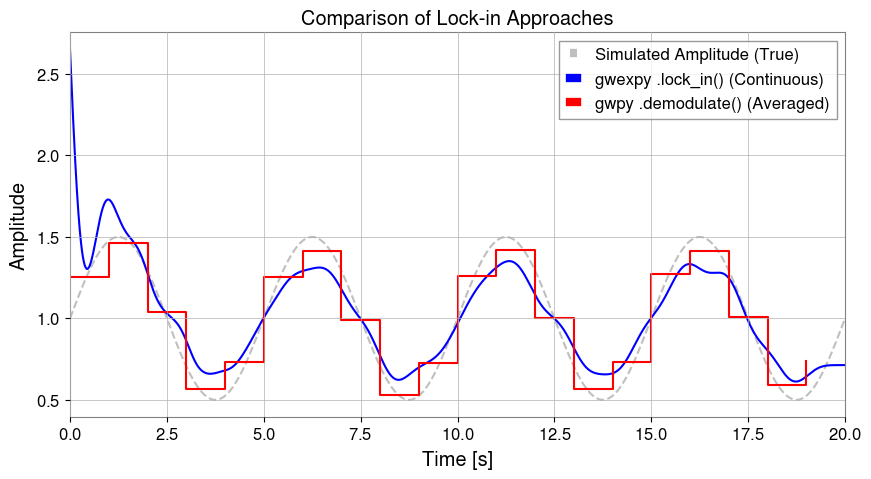

gwpy output length: 20 points (1Hz)
gwexpy output length: 20000 points (1000Hz)


In [6]:
fs = 1000
t = np.linspace(0, 20, 20*fs, endpoint=False)
f_carrier = 100
amp_sim = 1.0 + 0.5 * np.sin(2 * np.pi * 0.2 * t)
phase_sim = 0.5 * np.sin(2 * np.pi * 0.05 * t)
noise = np.random.normal(scale=0.5, size=len(t))
sig = amp_sim * np.cos(2 * np.pi * f_carrier * t + phase_sim) + noise
ts = TimeSeries(sig, sample_rate=fs, t0=0)

# 1. gwpy の手法 (demodulate)
# stride=1.0秒ごとに1点の平均値を算出
amp_gwpy, phase_gwpy = ts.demodulate(f_carrier, stride=1.0)

# 2. gwexpy の手法 (lock_in)
# サンプリングレートを維持したまま LPF を適用
amp_gwexpy, phase_gwexpy = ts.lock_in(f_carrier, bandwidth=1.0)

# 振幅 (Magnitude) の比較プロット
plt.figure(figsize=(10, 5))
plt.plot(t, amp_sim, label='Simulated Amplitude (True)', color='gray', alpha=0.5, linestyle='--')
plt.plot(amp_gwexpy, label='gwexpy .lock_in() (Continuous)', color='blue')
plt.step(amp_gwpy.times, amp_gwpy.value, label='gwpy .demodulate() (Averaged)', color='red', where='post')

plt.title("Comparison of Lock-in Approaches")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.show()

print(f"gwpy output length: {len(amp_gwpy)} points (1Hz)")
print(f"gwexpy output length: {len(amp_gwexpy)} points ({fs}Hz)")

### [補足] ホモダインとヘテロダインの違いに関する注意

物理学・電子工学の一般的な定義と、このソフトウェアパッケージ（gwpy/gwexpy）における実用上の違いを整理します。

結論から言うと、**gwpy の `.heterodyne()` メソッドは、物理的には「ホモダイン検波」を行っています**。名前が紛らわしいですが、実態はどちらも「信号周波数と一致した参照信号を掛け合わせる」操作です。

#### 1. 物理・工学的な定義

| 用語 | LO周波数 ($f_{LO}$) と信号周波数 ($f_{sig}$) の関係 | 結果の周波数 | 目的 |
| --- | --- | --- | --- |
| **ホモダイン (Homodyne)** | **同じ** ($f_{LO} = f_{sig}$) | **0 Hz (DC)** | 振幅と位相の抽出（ロックインアンプなど） |
| **ヘテロダイン (Heterodyne)** | **異なる** ($f_{LO} \neq f_{sig}$) | **差分周波数 (IF)** | 周波数変換（ラジオのチューニングなど） |

*   **ホモダイン**: ターゲット周波数を直接 0Hz (直流) に落とし込みます。
*   **ヘテロダイン**: ターゲット周波数を「中間周波数 (IF)」という扱いやすい別の周波数にずらします。

---

#### 2. gwpy / gwexpy パッケージにおける扱い

ここが少しややこしい点ですが、重力波解析のコード（LALやgwpy）では、**「特定の周波数を 0Hz にシフトして振幅と位相を取り出す操作」**のことを、慣習的に `.heterodyne()` と呼ぶことがあります。

しかし、やっている計算は以下の通りです：

$z(t) = x(t) \cdot e^{-i 2 \pi f_c t}$

ここでターゲット周波数 $f_c$ を信号周波数と **一致させている** ため、物理的には **ホモダイン検波** です。

##### 実装上の違いまとめ

| メソッド | パッケージ | 物理的動作 | 後処理 (Post-Processing) | 特徴 |
| --- | --- | --- | --- | --- |
| `.heterodyne()` | `gwpy` | **ホモダイン** | **単純平均 (Mean)** | 1秒ごとの平均値など、粗いデータになる。 |
| `.lock_in()` | `gwexpy` | **ホモダイン** | **ローパスフィルタ (LPF)** | 時間分解能を保ったまま、滑らかな時系列になる。 |

#### 結論

*   **物理的な意味**: ホモダインはDCへの変換、ヘテロダインはIFへの変換です。
*   **コード上の意味**: `gwpy.heterodyne()` も `gwexpy.lock_in()` も、ターゲット周波数をDCへ変換する（＝物理的にはホモダイン）点は同じです。違いは**「ノイズをどうやって除去するか（平均化 vs フィルタ）」**だけです。

ですので、制御信号の解析などで「ホモダイン検波をしたい」と思った場合、**`.lock_in()` を使えば正解**です（`.heterodyne()` を使うとデータが間引かれてしまいます）。